# Telepromter adatok elemzése - 3. Házi Data Science Verseny - Jákob Tamás

# 6. ML megoldás

Ebben a részben egy olyan ML megoldás megalkotása a cél, ami után magyarázni tudjuk az egyes eventek meglétének vagy számosságának fontosságát annak a függvényében, hogy a felhasználóból előfizető lett-e végül.

Nem az összes eseményt veszem figyelembe, hanem minden felhasználónál a felhasználónkénti első trial_started_event -> (trial_converted_event || trial cancelled_eventig) átmenetet.


In [1]:
from plotnine import (ggplot, aes, geom_histogram, geom_path, theme_minimal, 
                    labs, annotate, geom_point, geom_smooth, scale_fill_manual, geom_bar, 
                    coord_flip, theme,element_text, geom_text, position_stack, geom_line,
                    ylim, scale_fill_brewer, geom_col, scale_fill_gradient, geom_vline, geom_hline)
import numpy as np
import polars as pl
import pandas as pd
import pyarrow
from pycaret.classification import *
from pycaret.clustering import *
import umap
from scipy.stats import mannwhitneyu
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display
import plotly
import plotly.io as pio
pio.renderers.default = "iframe"

pd.set_option('display.max_rows', 101)
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)

np.random.seed(42)

In [2]:
aggregated_and_pivoted_users_df_with_transitions = filtered_df = pl.scan_parquet("./data/aggregated_and_pivoted_users_df_with_transitions.parquet").collect()

In [3]:
trial_transitions = ['trial_started_event -> trial_cancelled_event', 'trial_started_event -> trial_converted_event']
trial_transitions

['trial_started_event -> trial_cancelled_event',
 'trial_started_event -> trial_converted_event']

Elkészítem a target oszlopot az ML-hez:

In [4]:
aggregated_and_pivoted_users_df_with_transitions_with_target = aggregated_and_pivoted_users_df_with_transitions.with_columns([
    pl.when(pl.col("transition") == trial_transitions[0]).then(0).otherwise(1).alias("target")
]).drop("transition").drop("distinct_id")

In [6]:
aggregated_and_pivoted_users_df_with_transitions_with_target = aggregated_and_pivoted_users_df_with_transitions_with_target.drop([col for col in aggregated_and_pivoted_users_df_with_transitions_with_target.columns if col.endswith("trial_converted_event")])
aggregated_and_pivoted_users_df_with_transitions_with_target = aggregated_and_pivoted_users_df_with_transitions_with_target.drop([col for col in aggregated_and_pivoted_users_df_with_transitions_with_target.columns if col.endswith("trial_cancelled_event")])
aggregated_and_pivoted_users_df_with_transitions_with_target

country_code,event_count_RecordViewController.startSpeechRecognizing,event_count_SetLexendFont,event_count_VideoPreview,event_count_VideoPreviewScreen.SaveSuccess,event_count_Visual,event_count_SetOpenDyslexicFont,event_count_Replace,event_count_AI,event_count_ScriptGeneratorScreen,event_count_trigger_fire,event_count_Practice,event_count_Live,event_count_purchase_abandoned,event_count_Intercom,event_count_blur,event_count_capture,event_count_PlayerViewControllerSpeechRecognizing,event_count_ShowReferralScreen,event_count_Trim,event_count_LiveTutorial,event_count_SubtitleStyleSelectorViewController.styleSelected,event_count_Margin,event_count_Resize,event_count_LiveURL,event_count_Video,event_count_ConnectAccount,event_count_save,event_count_Remote,event_count_AppStorePromoPurchase,event_count_Onboarding,event_count_account,event_count_Web,event_count_FBApp,event_count_SignOut,event_count_Shortcut,event_count_New,…,first_event_time_SignOut,first_event_time_Shortcut,first_event_time_New,first_event_time_Preview,first_event_time_first_seen,first_event_time_PlainTextExport,first_event_time_send,first_event_time_freeTrial_start,first_event_time_Rephrase,first_event_time_reset,first_event_time_transaction_complete,first_event_time_Copied,first_event_time_sourceSelected,first_event_time_LiveStreamLink,first_event_time_ShowRemoteEdit,first_event_time_type,first_event_time_setNew,first_event_time_Could,first_event_time_GameControllerManager.Connected,first_event_time_bionic,first_event_time_ConnectYouTube,first_event_time_Kids,first_event_time_RecordScreen4KTap,first_event_time_ShowTrialExtensionImmediately,first_event_time_Mirroring,first_event_time_ConnectFacebook,first_event_time_TrialScreenSubscribeTap,first_event_time_TrialExtensionScreen,first_event_time_transaction_start,first_event_time_Core,first_event_time_PastedSpeedAndFontsize,first_event_time_ShowRegistrationFromProfileSettings,first_event_time_cancel,first_event_time_import,first_event_time_FootPedalRemoteScreen,first_event_time_PresentationRemoteScreen,target
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
"""MY""",4,0,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,23258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""LK""",0,1,0,0,1,1,0,3,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""UA""",0,0,60,8,0,0,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""ID""",0,0,14,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""BG""",0,0,161,12,1,0,5,0,0,0,0,0,0,0,3,2,0,0,20,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""CD""",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""NL""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""US""",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Inbalanced dataset, downsampling-ot használok a nem előfizető userekre.

Kitörlöm a "country_code" oszlopot, mert túl erős változó, és elnomja az események számát.

In [7]:
def balace_the_useres(df, target="target"):
    minority = df.filter(pl.col(target) == 1)
    majority = df.filter(pl.col(target) == 0)
    n_minority = minority.height
    n_majority = majority.height
    print("A", target, "oszlopban az 1 értékek száma:", n_minority)
    print("A", target, "oszlopban a 0 értékek száma:", n_majority)
    majority_sampled = majority.sample(n=n_minority, with_replacement=False, shuffle=True, seed=42)
    df = pl.concat([minority, majority_sampled]).with_columns(pl.lit(np.random.rand(minority.height * 2)).alias("rnd")).sort("rnd").drop("rnd")
    return df

balanced_df = balace_the_useres(aggregated_and_pivoted_users_df_with_transitions_with_target, target = "target").drop("country_code")
balanced_df

A target oszlopban az 1 értékek száma: 2017
A target oszlopban a 0 értékek száma: 10953


event_count_RecordViewController.startSpeechRecognizing,event_count_SetLexendFont,event_count_VideoPreview,event_count_VideoPreviewScreen.SaveSuccess,event_count_Visual,event_count_SetOpenDyslexicFont,event_count_Replace,event_count_AI,event_count_ScriptGeneratorScreen,event_count_trigger_fire,event_count_Practice,event_count_Live,event_count_purchase_abandoned,event_count_Intercom,event_count_blur,event_count_capture,event_count_PlayerViewControllerSpeechRecognizing,event_count_ShowReferralScreen,event_count_Trim,event_count_LiveTutorial,event_count_SubtitleStyleSelectorViewController.styleSelected,event_count_Margin,event_count_Resize,event_count_LiveURL,event_count_Video,event_count_ConnectAccount,event_count_save,event_count_Remote,event_count_AppStorePromoPurchase,event_count_Onboarding,event_count_account,event_count_Web,event_count_FBApp,event_count_SignOut,event_count_Shortcut,event_count_New,event_count_Preview,…,first_event_time_SignOut,first_event_time_Shortcut,first_event_time_New,first_event_time_Preview,first_event_time_first_seen,first_event_time_PlainTextExport,first_event_time_send,first_event_time_freeTrial_start,first_event_time_Rephrase,first_event_time_reset,first_event_time_transaction_complete,first_event_time_Copied,first_event_time_sourceSelected,first_event_time_LiveStreamLink,first_event_time_ShowRemoteEdit,first_event_time_type,first_event_time_setNew,first_event_time_Could,first_event_time_GameControllerManager.Connected,first_event_time_bionic,first_event_time_ConnectYouTube,first_event_time_Kids,first_event_time_RecordScreen4KTap,first_event_time_ShowTrialExtensionImmediately,first_event_time_Mirroring,first_event_time_ConnectFacebook,first_event_time_TrialScreenSubscribeTap,first_event_time_TrialExtensionScreen,first_event_time_transaction_start,first_event_time_Core,first_event_time_PastedSpeedAndFontsize,first_event_time_ShowRegistrationFromProfileSettings,first_event_time_cancel,first_event_time_import,first_event_time_FootPedalRemoteScreen,first_event_time_PresentationRemoteScreen,target
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
0,0,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,2,0,0,0,0,0,1,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,15,1,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,88,15,0,0,0,1,1,0,0,0,0,0,0,0,0,0,4,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,6,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
from pycaret.classification import ClassificationExperiment

In [13]:
s = ClassificationExperiment()
s.setup(balanced_df.to_pandas(), target = 'target', session_id = 123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(4032, 139)"
4,Transformed data shape,"(4032, 139)"
5,Transformed train set shape,"(2822, 139)"
6,Transformed test set shape,"(1210, 139)"
7,Numeric features,138
8,Preprocess,True
9,Imputation type,simple


In [14]:
bests = s.compare_models(n_select=20)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6304,0.6710,0.5542,0.6555,0.6002,0.2608,0.2644,0.3140
lightgbm,Light Gradient Boosting Machine,0.6286,0.6789,0.5988,0.6390,0.6174,0.2573,0.2585,0.1980
et,Extra Trees Classifier,0.6205,0.6516,0.6343,0.6189,0.6260,0.2410,0.2413,0.2670
ada,Ada Boost Classifier,0.6155,0.6497,0.5223,0.6422,0.5757,0.2311,0.2354,0.1710
rf,Random Forest Classifier,0.6130,0.6620,0.6470,0.6076,0.6260,0.2261,0.2269,0.2870
ridge,Ridge Classifier,0.6017,0.6422,0.3990,0.6747,0.5000,0.2034,0.2240,0.0460
lda,Linear Discriminant Analysis,0.6003,0.6421,0.3990,0.6722,0.4993,0.2006,0.2209,0.0570
dt,Decision Tree Classifier,0.5953,0.5953,0.6038,0.5933,0.5982,0.1906,0.1909,0.0560
knn,K Neighbors Classifier,0.5801,0.6096,0.5472,0.5860,0.5657,0.1602,0.1607,0.0480
nb,Naive Bayes,0.5298,0.6351,0.0900,0.7600,0.1604,0.0595,0.1278,0.0500


In [15]:
s.evaluate_model(bests[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Hyperparaméter tunning

In [ ]:
# Finomhangolás 5-szörös crossvalidációval

#classification = setup(balanced_df.to_pandas(), session_id = 124)
#gbc = create_model('gbc')
# tuned_dt = tune_model(lightgbm)

## A fontos tényezők vizualizációja

Átlagos felhasználó előállítása

In [8]:
mean_user = balanced_df.mean().select(pl.all().ceil())
mean_user

event_count_RecordViewController.startSpeechRecognizing,event_count_SetLexendFont,event_count_VideoPreview,event_count_VideoPreviewScreen.SaveSuccess,event_count_Visual,event_count_SetOpenDyslexicFont,event_count_Replace,event_count_AI,event_count_ScriptGeneratorScreen,event_count_trigger_fire,event_count_Practice,event_count_Live,event_count_purchase_abandoned,event_count_Intercom,event_count_blur,event_count_capture,event_count_PlayerViewControllerSpeechRecognizing,event_count_ShowReferralScreen,event_count_Trim,event_count_LiveTutorial,event_count_SubtitleStyleSelectorViewController.styleSelected,event_count_Margin,event_count_Resize,event_count_LiveURL,event_count_Video,event_count_ConnectAccount,event_count_save,event_count_Remote,event_count_AppStorePromoPurchase,event_count_Onboarding,event_count_account,event_count_Web,event_count_FBApp,event_count_SignOut,event_count_Shortcut,event_count_New,event_count_Preview,…,first_event_time_SignOut,first_event_time_Shortcut,first_event_time_New,first_event_time_Preview,first_event_time_first_seen,first_event_time_PlainTextExport,first_event_time_send,first_event_time_freeTrial_start,first_event_time_Rephrase,first_event_time_reset,first_event_time_transaction_complete,first_event_time_Copied,first_event_time_sourceSelected,first_event_time_LiveStreamLink,first_event_time_ShowRemoteEdit,first_event_time_type,first_event_time_setNew,first_event_time_Could,first_event_time_GameControllerManager.Connected,first_event_time_bionic,first_event_time_ConnectYouTube,first_event_time_Kids,first_event_time_RecordScreen4KTap,first_event_time_ShowTrialExtensionImmediately,first_event_time_Mirroring,first_event_time_ConnectFacebook,first_event_time_TrialScreenSubscribeTap,first_event_time_TrialExtensionScreen,first_event_time_transaction_start,first_event_time_Core,first_event_time_PastedSpeedAndFontsize,first_event_time_ShowRegistrationFromProfileSettings,first_event_time_cancel,first_event_time_import,first_event_time_FootPedalRemoteScreen,first_event_time_PresentationRemoteScreen,target
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,19.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,…,1547.0,1258.0,293.0,3682.0,4059.0,1128.0,2.0,210.0,1228.0,505.0,210.0,133.0,95.0,333.0,139.0,96.0,316.0,227.0,7.0,47.0,156.0,105.0,1.0,547.0,1.0,423.0,30.0,410.0,0.0,0.0,0.0,66.0,410.0,19.0,0.0,1.0,1.0


A modell szemponjából az 10 legfontosabb paraméter kieszedése a modellből:

In [17]:
model = bests[0]
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':mean_user.drop("target").columns}).sort_values("Value", ascending = False)
top_10_features = feature_imp.iloc[:10,1].tolist()
top_10_20_features = feature_imp.iloc[10:20,1].tolist()
top_10_features

['first_event_time_VideoPreviewScreen.SaveSuccess',
 'event_count_VideoPreview',
 'first_event_time_VideoPreview',
 'first_event_time_blur',
 'first_event_time_Visual',
 'first_event_time_capture',
 'first_event_time_first_seen',
 'first_event_time_Live',
 'first_event_time_SetOpenDyslexicFont',
 'event_count_VideoPreviewScreen.SaveSuccess']

### Részleges hatásdiagram előállítása

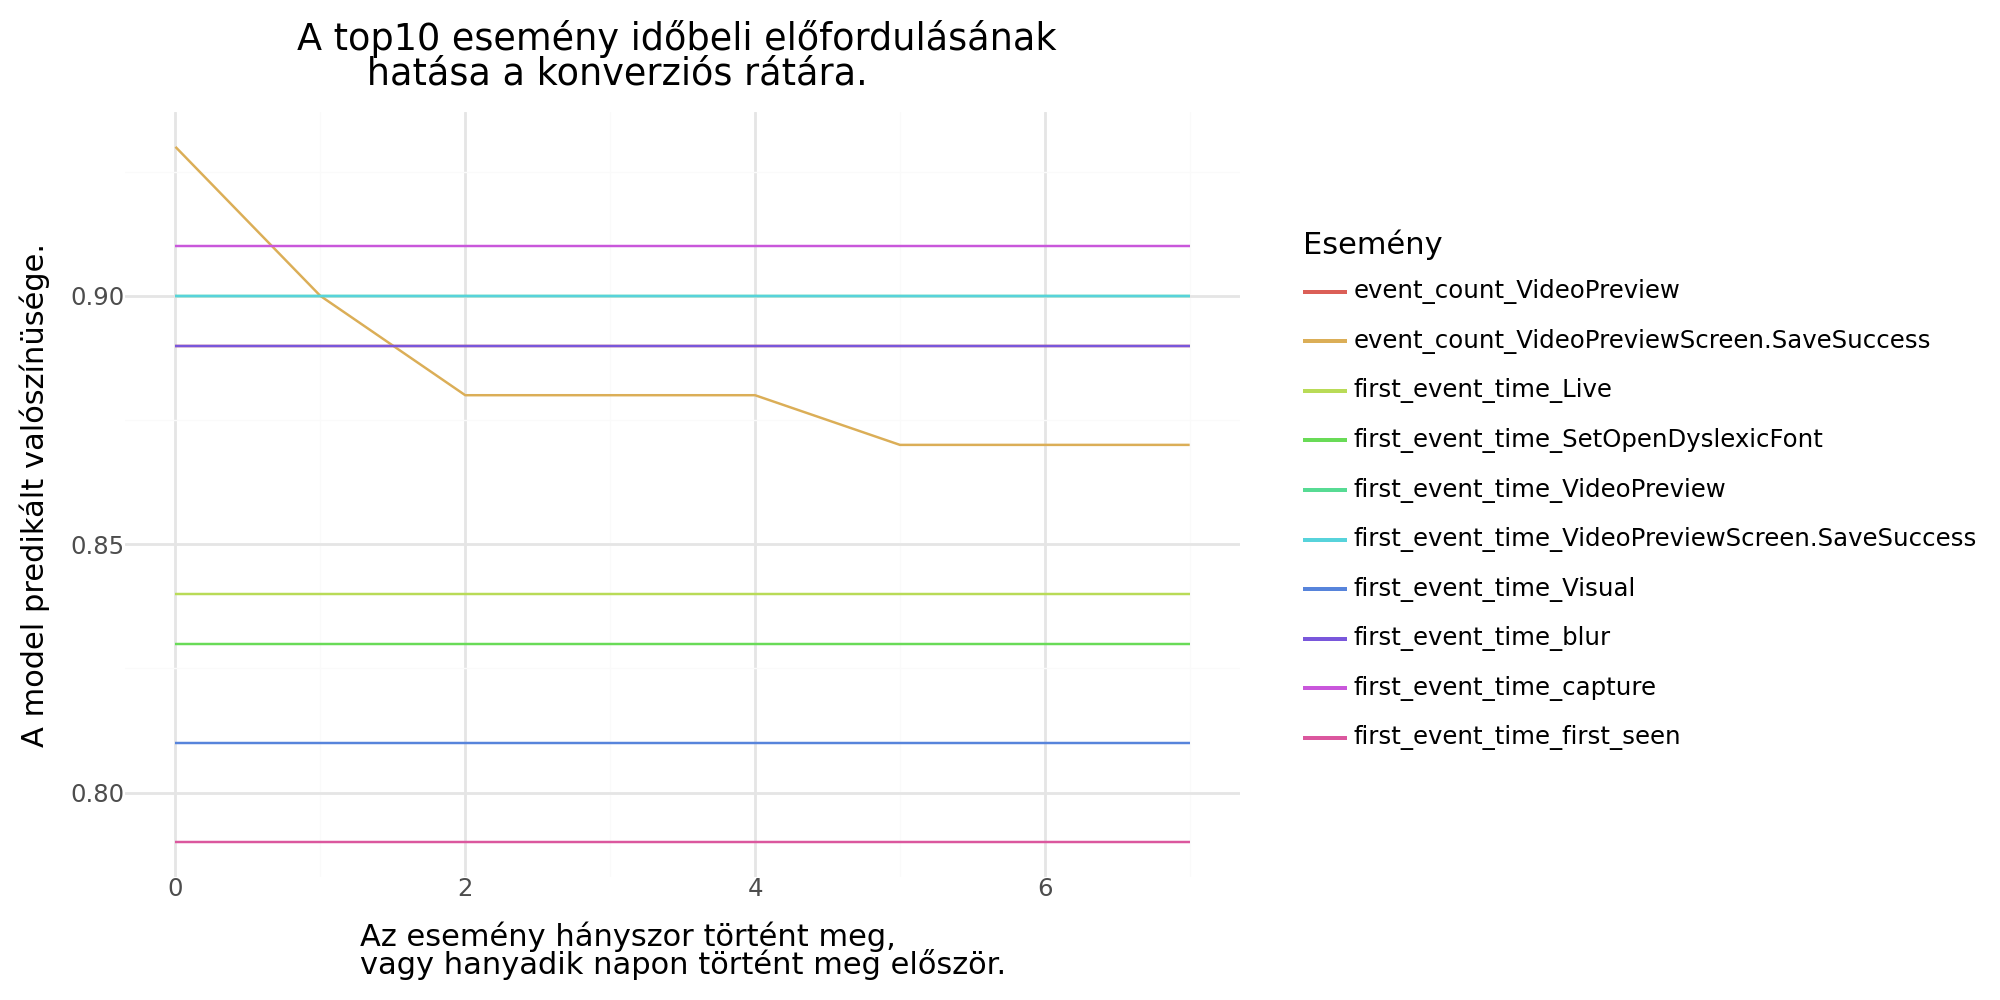

In [91]:
results = {}

values = [0, 1, 2, 3, 4, 5, 6, 7]
for feature in top_10_features:
    df_list = [mean_user.with_columns(pl.lit(v).alias(feature)).drop("target") for v in values]
    results[feature] = [model.predict_proba(i)[:,1][0].round(2) for i in df_list]

results_df = pd.DataFrame(results)
results_df_long = results_df.melt(var_name='Esemény', value_name='Érték', ignore_index=False)
results_df_long.reset_index(inplace=True)

top_10_plot = (ggplot(results_df_long, aes(x='index', y='Érték', color='Esemény')) + 
                        geom_line() +
                        theme_minimal() +
                        theme(figure_size=(10, 5)) +
                        labs(title="A top10 esemény időbeli előfordulásának \n        hatása a konverziós rátára.", x="Az esemény hányszor történt meg, \nvagy hanyadik napon történt meg először.", y="A model predikált valószínüsége.")
              ) 
                        

display(top_10_plot)
top_10_plot.save("./images/top_10_plot.png", dpi=300, transparent=True)

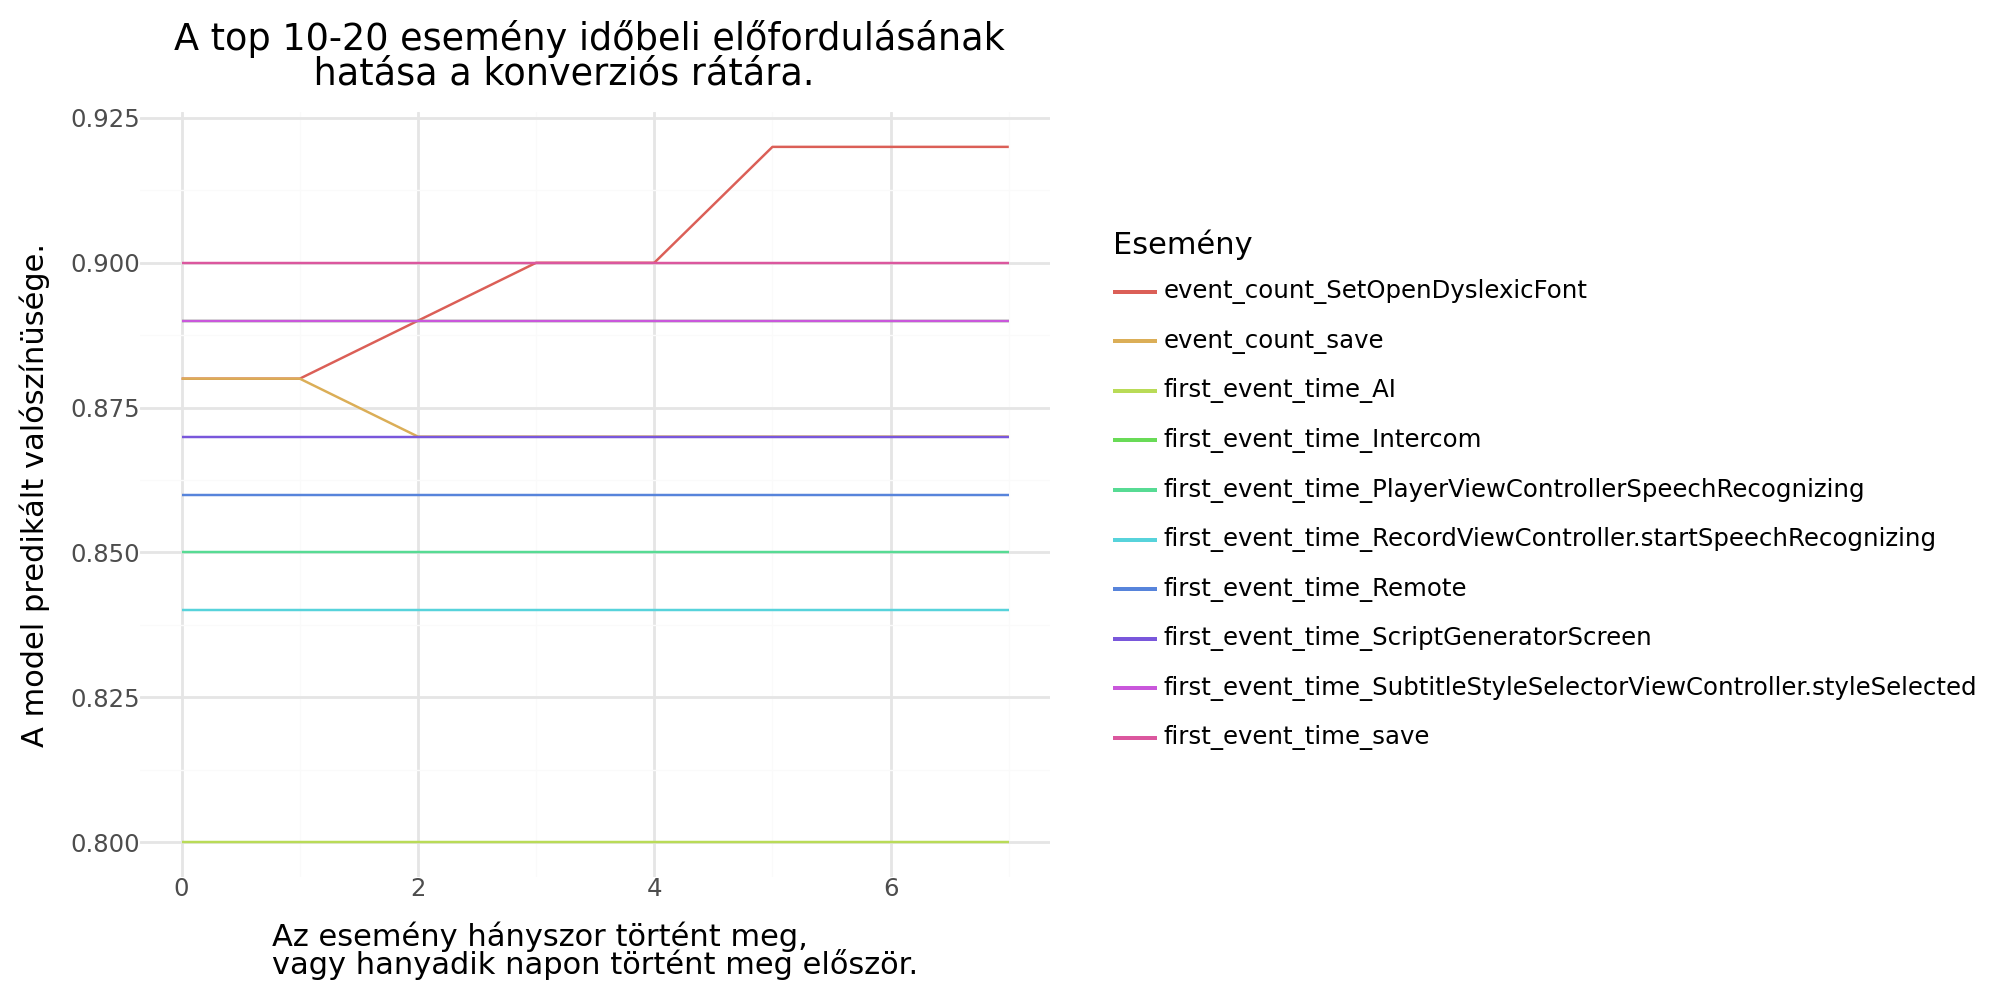

In [93]:
results = {}

values = [0, 1, 2, 3, 4, 5, 6, 7]
for feature in top_10_20_features:
    df_list = [mean_user.with_columns(pl.lit(v).alias(feature)).drop("target") for v in values]
    results[feature] = [model.predict_proba(i)[:,1][0].round(2) for i in df_list]

results_df = pd.DataFrame(results)
results_df_long = results_df.melt(var_name='Esemény', value_name='Érték', ignore_index=False)
results_df_long.reset_index(inplace=True)

top_10_20_plot = (ggplot(results_df_long, aes(x='index', y='Érték', color='Esemény')) + 
                        geom_line() +
                        theme_minimal() +
                        theme(figure_size=(10, 5)) +
                        labs(title="A top 10-20 esemény időbeli előfordulásának \n            hatása a konverziós rátára.", x="Az esemény hányszor történt meg, \nvagy hanyadik napon történt meg először.", y="A model predikált valószínüsége.") 
                        )

display(top_10_20_plot)
top_10_20_plot.save("./images/top_10_20_plot.png", dpi=300, transparent=True)

## 5.3 Korreláció vizsgálat

In [12]:
corr_matrix = balanced_df.to_pandas().corr(method='spearman')

In [14]:
corr_data = {"values": corr_matrix["target"], "event_name": corr_matrix.columns}

In [15]:
df_corr = pd.DataFrame(corr_data).sort_values("values", ascending = False)
df_corr.head(20)

,values,event_name
target,1.000000,target
event_count_VideoPreview,0.111320,event_count_VideoPreview
first_event_time_SetOpenDyslexicFont,0.097001,first_event_time_SetOpenDyslexicFont
event_count_SetOpenDyslexicFont,0.093540,event_count_SetOpenDyslexicFont
event_count_first_seen,0.091435,event_count_first_seen
first_event_time_first_seen,0.091262,first_event_time_first_seen
event_count_SubtitleStyleSelectorViewController.styleSelected,0.088217,event_count_SubtitleStyleSelectorViewControlle...
first_event_time_SubtitleStyleSelectorViewController.styleSelected,0.087227,first_event_time_SubtitleStyleSelectorViewCont...
event_count_AI,0.082314,event_count_AI
event_count_ScriptGeneratorScreen,0.082034,event_count_ScriptGeneratorScreen


## Session elemzés

In [16]:
full_filtered_df = pl.scan_parquet("full_filtered_df.parquet")
full_filtered_df.collect().head()

event,distinct_id,os_version,country_code,date,time_since_first_event,days,hours,minutes,seconds,groups
str,str,str,str,datetime[μs],duration[μs],i32,i32,i32,i32,str
"""secondOrMoreOpening""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272,"""Second"""
"""Homescreen""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272,"""Homescreen"""
"""checkSubscriptionStatus.Error""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272,"""checkSubscriptionStatus.Error"""
"""Branch.Log.Error""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272,"""branch"""
"""RemoteConfigManager.shared.rem…","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272,"""Remote"""


Előállítom a session id-kat. Userenként a 30 perc utáni apphasználatot számítom új sessionnek.

In [17]:
session_full_filtered_df = full_filtered_df.sort("distinct_id", "seconds").with_columns([
    pl.col("seconds").shift(-1).over("distinct_id").alias("next_seconds"),
    pl.col("groups").shift(-1).over("distinct_id").alias("next_group")
]).with_columns([
    (pl.col("next_seconds")-pl.col("seconds")).over("distinct_id").alias("time_diff"),
    (pl.col("groups") + " -> " + pl.col("next_group")).alias("transition")
]).drop(["os_version", "next_seconds"]).sort("distinct_id", "seconds").with_columns([
    pl.col('time_diff').fill_null(0)
])


In [18]:
session_full_filtered_df_flagged = (
        session_full_filtered_df
        .with_columns([
            # új oszlop: 1, ha event == "start", különben 0
            (pl.col("time_diff") > 30*60).over("distinct_id").cast(pl.Int8).alias("start_flag"),
    
        ])
        .with_columns([
            # számoljuk össze, hányadik "start" eseménynél vagyunk: ez lesz a session_id
            pl.col("start_flag").cum_sum().alias("session_id")
        ]).drop("start_flag")
    ).collect()

session_full_filtered_df_flagged.head()

event,distinct_id,country_code,date,time_since_first_event,days,hours,minutes,seconds,groups,next_group,time_diff,transition,session_id
str,str,str,datetime[μs],duration[μs],i32,i32,i32,i32,str,str,i32,str,i64
"""secondOrMoreOpening""","""$RCAnonymousID:user_0070011269…","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""Second""","""device_attributes""",0,"""Second -> device_attributes""",0
"""device_attributes""","""$RCAnonymousID:user_0070011269…","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""device_attributes""","""config_attributes""",0,"""device_attributes -> config_at…",0
"""config_attributes""","""$RCAnonymousID:user_0070011269…","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""config_attributes""","""user""",0,"""config_attributes -> user""",0
"""user_attributes""","""$RCAnonymousID:user_0070011269…","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""user""","""app""",0,"""user -> app""",0
"""app_launch""","""$RCAnonymousID:user_0070011269…","""US""",2025-01-22 07:47:00,0µs,0,0,0,0,"""app""","""session""",0,"""app -> session""",0


Aggregálom az adatokat esemény csoportok szerint. A "distinct_id"-t és a "country_code"-ot továbbviszem, későbbi elemzésekhez.

In [19]:
session_full_filtered_df_flagged_groupped = session_full_filtered_df_flagged.group_by(['session_id', 'groups']).agg([
    pl.col("groups").count().alias("groups_count"),
    pl.col("distinct_id").first(),
    pl.col("country_code").first()
]).sort("session_id")

session_full_filtered_df_flagged_groupped.head(5)


session_id,groups,groups_count,distinct_id,country_code
i64,str,u32,str,str
0,"""$ae""",2,"""$RCAnonymousID:user_0070011269…","""US"""
0,"""TeleprompterDidLoaded""",2,"""$RCAnonymousID:user_0070011269…","""US"""
0,"""OpenScript""",1,"""$RCAnonymousID:user_0070011269…","""US"""
0,"""user""",1,"""$RCAnonymousID:user_0070011269…","""US"""
0,"""config_attributes""",2,"""$RCAnonymousID:user_0070011269…","""US"""


In [20]:
session_full_filtered_df_flagged_groupped_pivoted = session_full_filtered_df_flagged_groupped.pivot(
    values = ["groups_count"],
    index = ['session_id', 'distinct_id', "country_code"],
    columns = 'groups'
).fill_null(0).sort(["distinct_id", "session_id"])

session_full_filtered_df_flagged_groupped_pivoted.to_pandas().head(5)

,session_id,distinct_id,country_code,$ae,TeleprompterDidLoaded,OpenScript,user,config_attributes,Homescreen,session,Rating,Second,Editorscreen,NoRatingBecauseOfNoSceneError,PlayerScreen,VideoPreviewScreen.SaveSuccess,app,Record,VideoPreview,device_attributes,branch,first_seen,trigger_fire,paywall,trial_converted_event,trial_started_event,Show,did_receive_asa_attribution,subscription,didRegister,create,RecordViewController.startSpeechRecognizing,Settings,Thank,deleteRecording,script,SettingsScreen,purchase,update,assigned,cancellation_event,remove,Whats,SelectPlatform,capture,start,setNew,userDidTakeScreenshotNotification,Font,SortingTap,...,WCSession*ERROR,open,send,deeplinkRemoteConnectUsed,ShowRemoteEdit,transaction_abandon,Video,account,setup,reset,SignOut,type,sourceSelected,bionic,Shortcut,Practice,save,Could,ShowReferralScreen,handle,LiveStreamLink,Select,chooseYoutube,chooseFacebook,Web,AudioCleaningError,Rephrase,initial_purchase_event,ConnectYouTube,Kids,Manage,documentPicker.Error,web,stop,ShowRegistrationFromProfileSettings,videorecorder,Tele,Copied,Core,PresentationRemoteScreen,FootPedalRemoteScreen,ConnectFacebook,GameControllerManager.Connected,FBApp,PastedSpeedAndFontsize,videoRecorderRecordingStarted,setScriptsToSynced.Error,Speech,sync,salesSentToAgent
0,0,$RCAnonymousID:user_00700112690657,US,2,2,1,1,2,1,1,1,1,1,1,2,1,8,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,$RCAnonymousID:user_00700112690657,US,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,$RCAnonymousID:user_00700112690657,NR,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,$RCAnonymousID:user_00700112690657,NR,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,$RCAnonymousID:user_00700112690657,NR,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Megnézem, hogy országonként átlagosan hány sessiont indítottak a felhasználók.

In [21]:
avg_sessions_per_user_per_country = (
    session_full_filtered_df_flagged_groupped_pivoted
    .group_by(["country_code", "distinct_id"])
    .agg(pl.count("session_id").alias("session_count"))
    .group_by("country_code")
    .agg(pl.mean("session_count").alias("avg_sessions_per_user"))
).sort("avg_sessions_per_user")

In [22]:
country_df = pl.scan_parquet("./data/country_df.parquet").collect()
df_pivoted = pl.scan_parquet("./data/df_pivoted.parquet").collect()

In [23]:
avg_sessions_per_user_per_country_full = avg_sessions_per_user_per_country.join(country_df, how = 'left', on = 'country_code')

In [24]:
avg_sessions_per_user_per_country_full2 = avg_sessions_per_user_per_country_full.join(df_pivoted, on = "country_name", how = 'left')

In [25]:
avg_sessions_per_user_per_country_full2 = avg_sessions_per_user_per_country_full2.filter(~pl.col("cancelled_to_converted_ratio (%)").is_nan())

In [26]:
avg_sessions_per_user_per_country_full2

country_code,avg_sessions_per_user,country_name,trial_cancelled_event,trial_converted_event,cancelled_to_converted_ratio (%)
str,f64,str,u32,u32,f64
"""NR""",3.786492,"""Nauru""",175,88,33.460076
"""ID""",3.843144,"""Indonesia""",3020,41,1.339432
"""RU""",4.081633,"""Russian Federation""",442,24,5.150215
"""NL""",4.282297,"""Netherlands""",152,37,19.57672
"""UA""",4.55163,"""Ukraine""",699,51,6.8
…,…,…,…,…,…
"""JP""",5.717949,"""Japan""",103,50,32.679739
"""IL""",5.729032,"""Israel""",113,49,30.246914
"""CA""",5.755682,"""Canada""",129,42,24.561404


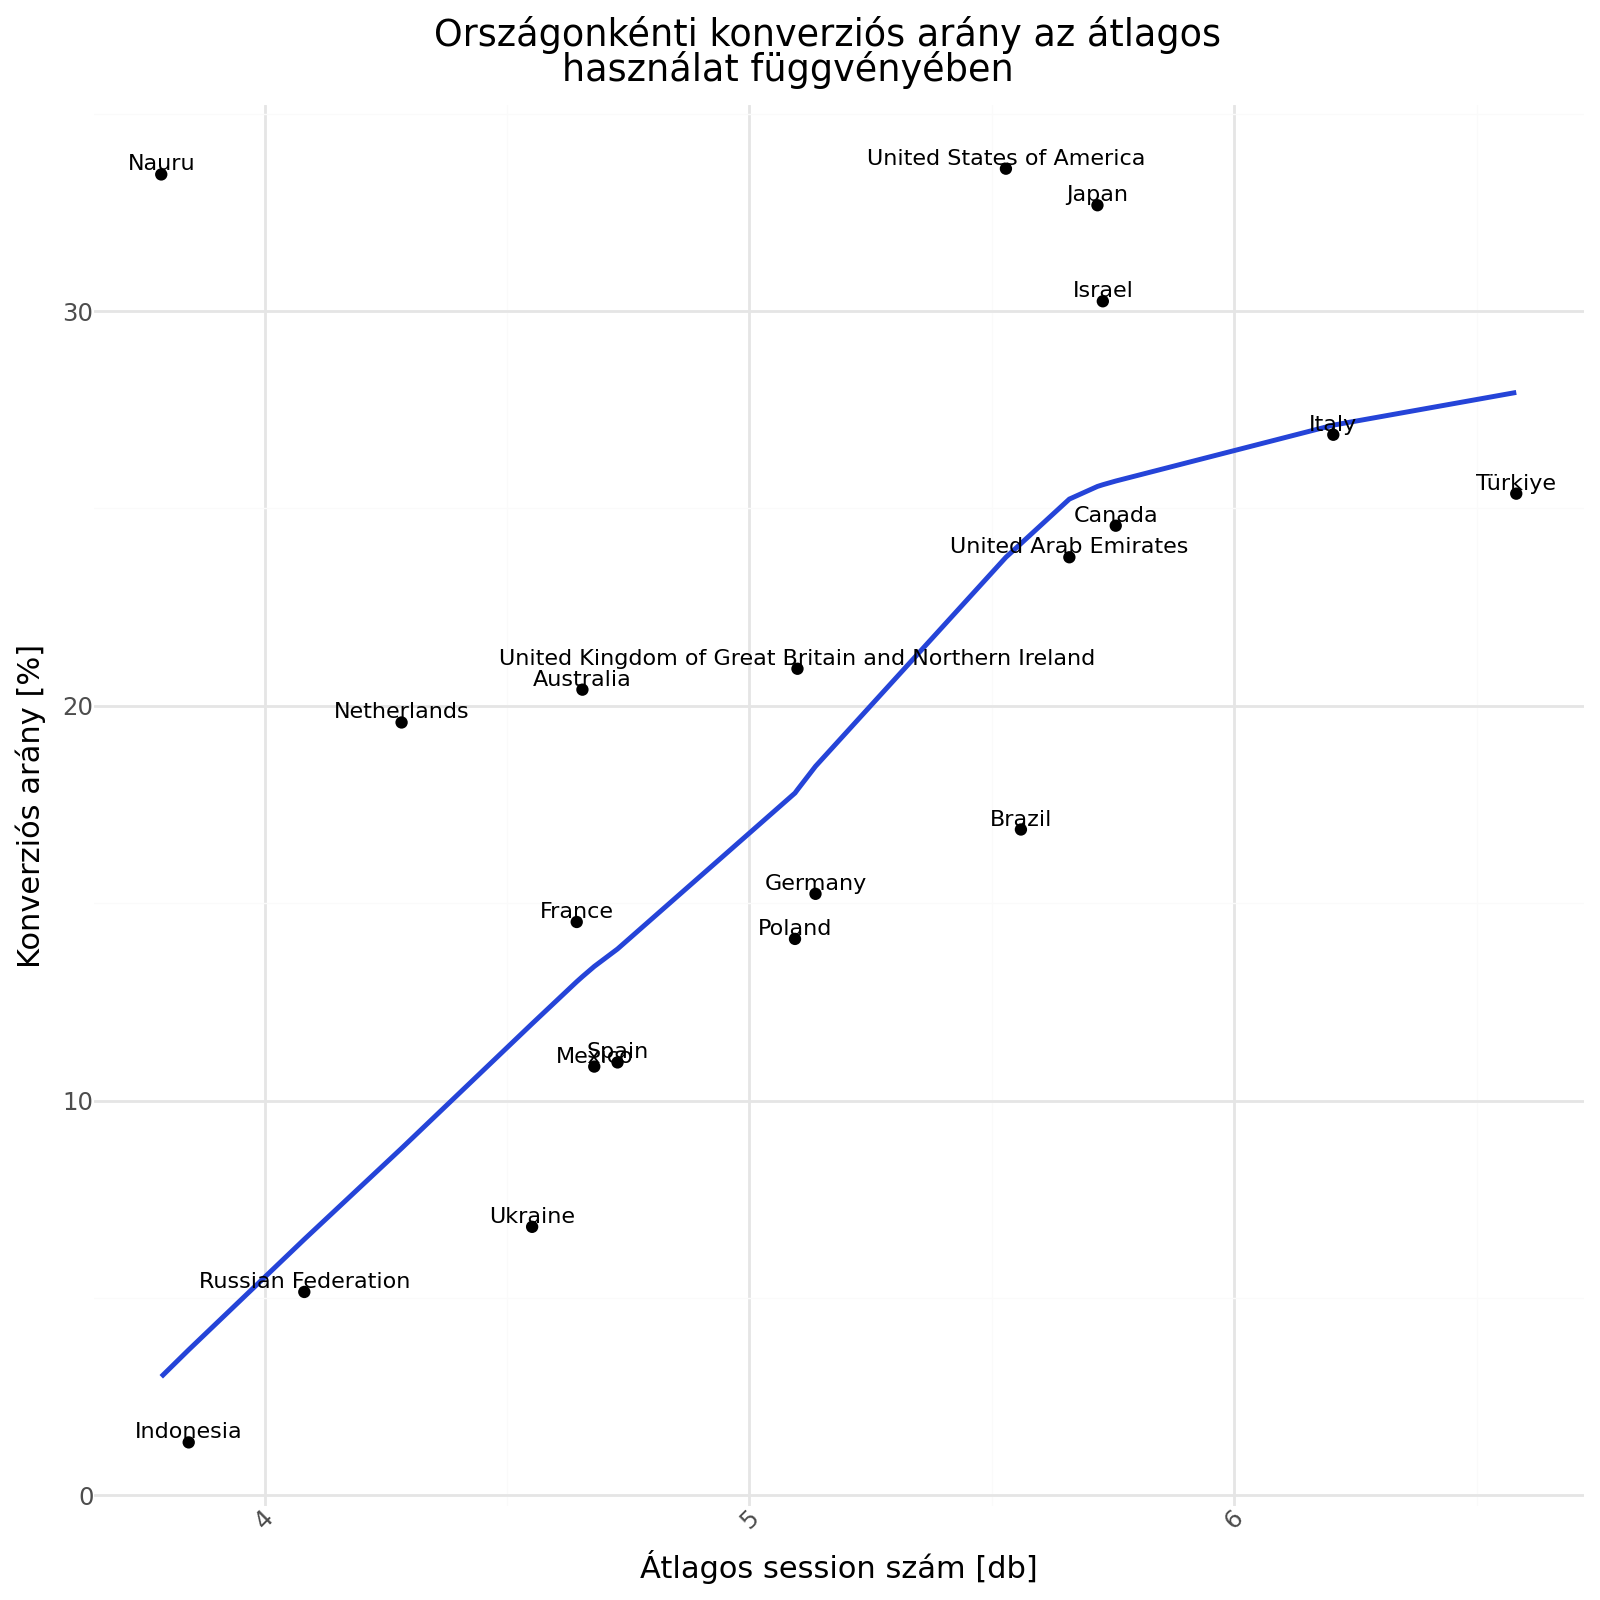

In [28]:
session_plot = (
    ggplot(avg_sessions_per_user_per_country_full2, aes(x="avg_sessions_per_user", y="cancelled_to_converted_ratio (%)")) +
    geom_point() +
    geom_smooth(color="#2544d8") +
    theme_minimal() +
    theme(axis_text_x=element_text(angle=45), figure_size=(8, 8), plot_caption=element_text(size=10, color="gray", ha="left")) +
    geom_text(aes(label="country_name"), va="bottom", ha="center", size=8, angle=0) +
    labs(title="Országonkénti konverziós arány az átlagos  \n           használat függvényében", 
         x="Átlagos session szám [db]", 
         y="Konverziós arány [%]")
)
display(session_plot)
session_plot.save("./images/session_plot.png", dpi=300, transparent=True)

## Klaszterezés

A korábbi tapasztalatok alapján a felhasználók vagy a sessionok klaszterezését nem végzem, mert nem várható belőle extra információ.


In [ ]:
cluster = setup(data=session_full_filtered_df_flagged_groupped_pivoted.drop('session_id'), normalize=True, session_id=42, verbose = False)
kmeans_model = create_model('kmeans', num_clusters=4)
plot_model(kmeans_model, plot='elbow')

In [ ]:
evaluate_model(kmeans_model)

In [ ]:
dbscan_model = create_model('dbscan')

In [ ]:
evaluate_model(dbscan_model)